<a href="https://colab.research.google.com/github/PadamSharma/Stock_Price_Prediction/blob/main/Stock_price_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!unzip /content/drive/MyDrive/StockPricePrediction/stock_dataset.zip

Archive:  /content/drive/MyDrive/StockPricePrediction/stock_dataset.zip
replace GOOG.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: GOOG.csv                
  inflating: AAPL.csv                
  inflating: AMZN.csv                
  inflating: TSLA.csv                
  inflating: MSFT.csv                


In [11]:
import warnings
warnings.filterwarnings("ignore")

import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Bidirectional, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size = 16 * tpu_strategy.num_replicas_in_sync


Running on TPU  ['10.4.87.90:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.4.87.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.87.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [13]:
companies = ['GOOG', 'AAPL', 'AMZN', 'TSLA', 'MSFT']

In [14]:
def stock_price_dataset(company):
    df = pd.read_csv('/content/'+company+'.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] > '2015-01-05']
    df_test = df[df['Date'] > '2020-09-03']
    df_train = df[df['Date'] <='2020-09-01']
    train = df_train['Adj Close']
    test = df_test['Adj Close']
    test_date = df_test['Date']
    train = np.array(train)
    x = []
    y = []
    for i in range(len(train)-5):
        x.append(train[i:i+5])
        y.append(train[i+5])
    test = np.array(test)
    x = np.array(x).reshape(-1,5,1)
    y = np.array(y).reshape(-1,1)
    return x, y, test, test_date

In [15]:
def lrscheduler(epoch):
  
  if epoch <= 200:
    lrate = (10 ** -6)
  else:
    initial_lrate = (10 ** -6)
    k = 0.001
    lrate = initial_lrate * math.exp(-k * (epoch - 100))
  
  return lrate

In [16]:
callback_lr = tf.keras.callbacks.LearningRateScheduler(lrscheduler)

In [17]:
def train(i, company):
    with tpu_strategy.scope():
        model = tf.keras.models.Sequential([
                                        tf.keras.layers.LSTM(256, input_shape = (5, 1), activation = tf.nn.leaky_relu,return_sequences = True),
                                        tf.keras.layers.LSTM(256, input_shape = (5, 1), activation = tf.nn.leaky_relu),
                                        tf.keras.layers.Dense(256, activation = tf.keras.activations.swish),
                                        tf.keras.layers.Dense(128, activation = tf.keras.activations.swish),
                                        tf.keras.layers.Dense(64, activation = tf.keras.activations.swish),
                                        tf.keras.layers.Dense(32, activation = tf.keras.activations.swish),
                                        tf.keras.layers.Dense(1)
                                        ])
        
        model.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

        print('-'*25,"Company #",company,'-'*25)
        x, y, test, test_date = stock_price_dataset(company)
        history = model.fit(x,y,epochs=1000,verbose=0,callbacks=[callback_lr], batch_size=batch_size)

    rmse = history.history['root_mean_squared_error']
    loss = history.history['loss']

    x_test = []
    y_test = []
    for i in range(len(test)-5):
        x_test.append(test[i:i+5])
        y_test.append(test[i+5])

    x_test = np.array(x_test).reshape(-1, 5, 1)
    y_test = np.array(y_test).reshape(-1,)
    test_date = test_date[5:]
    test_date = np.array(test_date).reshape(-1,)

    predictions = model.predict(x_test)
    predictions = np.array(predictions).reshape(-1,)

    RMSE = math.sqrt(mean_squared_error(predictions, y_test))
    return RMSE, y_test, predictions, test_date

------------------------- Company # GOOG -------------------------
GOOG  : RMSE =>  44.45349425365997

------------------------- Company # AAPL -------------------------
AAPL  : RMSE =>  6.8014055130048465

------------------------- Company # AMZN -------------------------
AMZN  : RMSE =>  78.57363634402553

------------------------- Company # TSLA -------------------------
TSLA  : RMSE =>  39.322285894922864

------------------------- Company # MSFT -------------------------
MSFT  : RMSE =>  3.9462557474840327



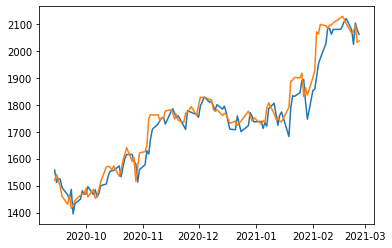

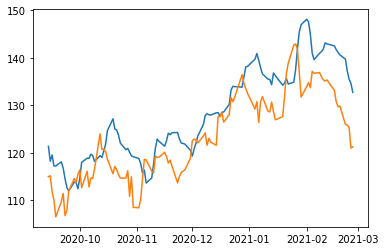

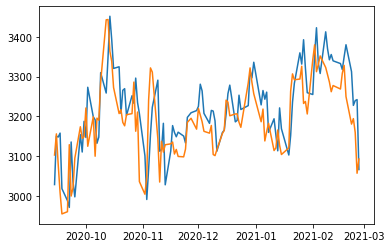

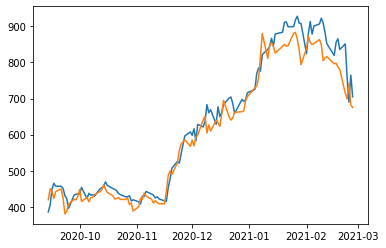

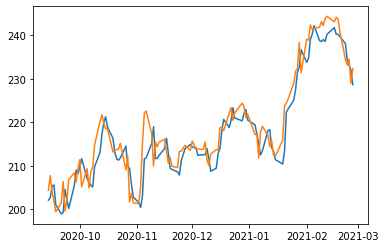

In [18]:
for i, company in enumerate(companies):
    rmse, y_test, predictions, test_date = train(i, company)
    plt.figure(i)
    sns.lineplot(x=test_date, y=predictions)
    sns.lineplot(x=test_date, y=y_test)
    print(company, " : RMSE => ", rmse)
    print()